In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, Headings
from qiskit_metal.qlibrary.qubits.transmon_cross import TransmonCross
from qiskit_metal.qlibrary.qubits.transmon_cross_fl import TransmonCrossFL
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround
from qiskit_metal.qlibrary.terminations.launchpad_wb import LaunchpadWirebond
from qiskit_metal.qlibrary.terminations.launchpad_wb_coupled import LaunchpadWirebondCoupled
from qiskit_metal.qlibrary.tlines.pathfinder import RoutePathfinder

In [4]:
def set_physical_parameter(value, units):
    if value == 0:
        return 0
    else:
        return str(value)+units

In [5]:
L_j = 10
C_j = 0

In [6]:
claw_length = 150
claw_width = 7
claw_gap = 6

In [7]:
claw_params = dict(connector_location = '180',
                 claw_length =  set_physical_parameter(claw_length, "um"),
                 claw_width = set_physical_parameter(claw_width, "um"),
                 claw_gap =  set_physical_parameter(claw_gap, "um"),
                 ground_spacing = '10um')

In [8]:
chip_x = 2
chip_y = 2

In [9]:
%matplotlib inline
import numpy as np
from qiskit_metal.analyses.quantization import EPRanalysis
import pyEPR as epr
import pandas as pd
import csv  


In [10]:
def start_GUI_session(cross_gap, cross_width, cross_length, L_j, C_j, claw_params, chip_x, chip_y):
    design = designs.DesignPlanar({}, True)
    design.delete_all_components()

    design.chips.main.size['size_x'] = set_physical_parameter(chip_x, "mm")
    design.chips.main.size['size_y'] = set_physical_parameter(chip_y, "mm")
    
    gui = MetalGUI(design)
    
    transmon_options = dict(
        chip = 'main',
        pos_x = '-1mm',
        cross_gap = set_physical_parameter(cross_gap, "um"), 
        cross_width = set_physical_parameter(cross_width, "um"), 
        cross_length = set_physical_parameter(cross_length, "um"), 
        hfss_inductance = set_physical_parameter(L_j, "nH"),
        hfss_capacitance = set_physical_parameter(C_j, "fF"),
        q3d_inductance = set_physical_parameter(L_j, "nH"),
        q3d_capacitance = set_physical_parameter(C_j, "fF"),
        connection_pads=dict(
        claw = claw_params,
        )
    )
    
    q1 = TransmonCrossFL(design, 'Q1', options = transmon_options)
    gui.rebuild()
    gui.autoscale()
    gui.screenshot()
    return q1, design, transmon_options

def start_EPR(q1, design, transmon_options, resistance=50, passes=3):
    eig_qb = EPRanalysis(design, "hfss")
    hfss = eig_qb.sim.renderer
    started = hfss.start()
    if started:
        gap, width, length = transmon_options["cross_gap"], transmon_options["cross_width"], transmon_options["cross_length"]
        project_name = f"OCS_gap{gap}_width{width}_length{length}"
        hfss.new_ansys_design(project_name, 'eigenmode')
        hfss.render_design(
        selection=['Q1'],  open_pins=[],  port_list=[("Q1","claw", resistance)], box_plus_buffer = True)
        # Analysis properties
        setup = hfss.pinfo.setup
        setup.passes = passes
        print(f"""
        Number of eigenmodes to find             = {setup.n_modes}
        Number of simulation passes              = {setup.passes}
        Convergence freq max delta percent diff  = {setup.delta_f}
        """)
        
        pinfo = hfss.pinfo
        pinfo.design.set_variable('Lj', set_physical_parameter(L_j, "nH"))
        pinfo.design.set_variable('Cj', set_physical_parameter(C_j, "fF"))

        setup.analyze()
        eig_qb.sim.convergence_t, eig_qb.sim.convergence_f, _ = hfss.get_convergences()
        eig_qb.sim.plot_convergences()
        freqs = eig_qb.sim.convergence_f["re(Mode(1)) [g]"].values
        freqs = freqs[~np.isnan(freqs)]
        qubit_freq = freqs[-1]
        pinfo = hfss.pinfo
        pinfo.junctions['jj'] = {'Lj_variable': 'Lj', 'rect': 'JJ_rect_Lj_Q1_rect_jj',
                                     'line': 'JJ_Lj_Q1_rect_jj_',  'Cj_variable': 'Cj'}
        pinfo.validate_junction_info() # Check that valid names of variables and objects have been supplied
        pinfo.dissipative['dielectrics_bulk'] = ['main'] # Dissipative elements: specify
                                 
        epra = epr.QuantumAnalysis(eprd.data_filename)
        sim_info = epra.analyze_all_variations(cos_trunc = 8, fock_trunc = 7)
        df = pd.DataFrame(sim_info, columns=sim_info.keys())                            
        EjEc_ratio = float(epra.get_Ejs('0')) / float(epra.get_Ecs('0'))
        alpha = df["0"]["chi_O1"].values[0][0] #?
        return gap, width, length, qubit_freq, alpha, df

def save2disk(gap, width, length, qubit_freq, alpha, df):
    base = "C:\\Users\\lfl\\OCS_Transmon_Qubit\\ocs_param_test\\"
    project_name = f"OCS_gap{gap}_width{width}_length{length}"
    df.to_csv(base+"\\dataframes\\"+project_name+".csv")

    header = ['qubit_freq','alpha']
    data = [qubit_freq, alpha,]
    oname = base+"\\info\\"+project_name+".csv"
    with open(oname, 'w', encoding='UTF8') as f:
        writer = csv.writer(f)
        writer.writerow(header)
        writer.writerow(data)
                

In [11]:
gaps = np.linspace(10,50,11)
widths = np.linspace(10,50,11)
lengths = np.linspace(100,500,11)


In [12]:
num_passes = 3

  arr = construct_1d_object_array_from_listlike(values)

  arr = construct_1d_object_array_from_listlike(values)

  arr = construct_1d_object_array_from_listlike(values)

  arr = construct_1d_object_array_from_listlike(values)

  arr = construct_1d_object_array_from_listlike(values)

  arr = construct_1d_object_array_from_listlike(values)



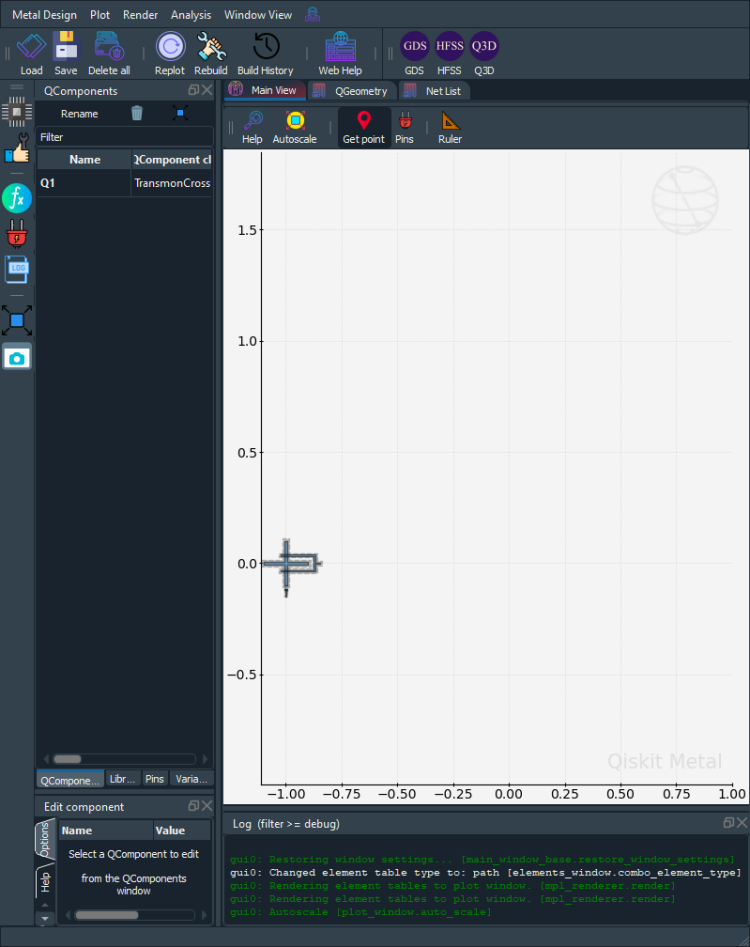

INFO 11:14PM [connect_project]: Connecting to Ansys Desktop API...
INFO 11:14PM [load_ansys_project]: 	Opened Ansys App
INFO 11:14PM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 11:14PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    D:/lfl/Documents/Ansoft/
	Project:   Project15
INFO 11:14PM [connect_design]: 	Opened active design
	Design:    OCS_gap10.0um_width10.0um_length100.0um [Solution type: Eigenmode]
INFO 11:14PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 11:14PM [connect]: 	Connected to project "Project15" and design "OCS_gap10.0um_width10.0um_length100.0um" 😀 

INFO 11:14PM [connect_design]: 	Opened active design
	Design:    OCS_gap10.0um_width10.0um_length100.0um1 [Solution type: Eigenmode]
WARNING 11:14PM [connect_setup]: 	No design setup detected.
WARNING 11:14PM [connect_setup]: 	Creating eigenmode default setup.
INFO 11:14PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 11:14PM [analy


        Number of eigenmodes to find             = 1
        Number of simulation passes              = 3
        Convergence freq max delta percent diff  = 0.1
        


11:14PM 19s INFO [get_f_convergence]: Saved convergences to C:\Users\lfl\OCS_Transmon_Qubit\hfss_eig_f_convergence.csv


In [ ]:
for length in lengths:
    for gap in gaps:
        for width in widths:
            try:
                q1, design, transmon_options = start_GUI_session(gap, width, length, L_j, C_j, claw_params, chip_x, chip_y)
                gap, width, length, qubit_freq, alpha, df = start_EPR(q1, design, transmon_options, passes=num_passes)
                save2disk(gap, width, length, qubit_freq, alpha, df)
            except:
                pass